# Facial Expression Classifier by Karel Fonteyn

> Implement in (Jupyter) Python Notebooks (mixing code and comments) an algorithm that classifies the facial expression from raw images or videos containing faces, based on facial landmarks to be detected in these images.

## Data

### FER+ Dataset

Facial expressions are complex, and expressions can be interpreted in varyious ways, depending on the context. Therefore, the data used to train the classifier is the FER+ dataset. This dataset extends the data of the original FER dataset which was constructed by Pierre Luc Carrier and Aaron Courville using the Google image search API (Goodfellow et al., 2015). The FER+ dataset uses the same images, but the labels have been re-tagged using crowd sourcing. The taggers had to assign for each image one of the following expressions: 'neutral', 'happy', 'sad', 'angry',  'surprised', 'disgusted', 'afraid' or 'in contempt'. Having 10 taggers individually assigning a label for every image, a more reliable result is achieved (see figure 1). (Barsoum et al., 2016)

For retrieving the dataset, please see [https://github.com/microsoft/FERPlus](https://github.com/microsoft/FERPlus). The original FER-2013 dataset can be found [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) and the FER+ labels [here](https://github.com/microsoft/FERPlus/blob/master/fer2013new.csv). The script provided by the FER+ dataset ([this script](https://github.com/microsoft/FERPlus/blob/master/src/generate_training_data.py)) was used to generate the dataset.

![FER versus FER+](./content/ferplus.png)

Figure 1: Examples of differences between FER en FER+. The top labels are from the FER-2013 dataset, the bottom labels from the FER+ dataset when using majority voting to decide on an expression. From Barsoum et al. (2016).

### Facial Landmarks

As stated in the assignment, facial landmarks should be used to classify expressions. The developed method uses 68 distinct facial landmarks to categorize expressions. 

#### Normalizing data

To make sure the trained model generalizes well to new data, the landmarks are normalized. This is done in two steps, which will convert the landmarks from image coordinates to a generalized vector encoding.

1. __Rotation invariance__ First, the landmarks are rotated to combat the influence of tilted faces. As proposed by Van Gent (2016), this is done by using the tip of the nose and the uppermost point of the bridge of the nose. The landmarks are rotated around the tip of the nose, so the line between this point and the uppermost point of the bridge of the nose is perfectly vertical. Since it is assumed the people in the images face the camera, this will correct the faces from their tilted positioning.

In [1]:
import math

def rotate_vector(center: tuple, point: tuple, angle: float):
    """Rotate a vector around a center point. Angle given in radians."""
    temp = (point[0] - center[0], point[1] - center[1])
    retval = (
        temp[0] * math.cos(angle) - temp[1] * math.sin(angle),
        temp[0] * math.sin(angle) + temp[1] * math.cos(angle)
    )
    return (retval[0] + center[0], retval[1] + center[1])

def get_nose_angle(landmarks: list):
    """Calculate angle between the tip of the nose (landmark 30) and the uppermost point of the bridge of the nose (landmark 27)."""
    if landmarks[27][0] == landmarks[30][0]:
        radians = 0
    else:
        radians = math.atan2(float(landmarks[30][0]-landmarks[27][0]),float(landmarks[30][1]-landmarks[27][1]))
    return radians
        
def rotate_landmarks(landmarks: list):
    """Rotate landmarks. Make sure the line between the tip of the nose and the uppermost point of the nose bridge is vertical.
    The parameter 'Landmarks' is an array of tuples (int, int), indicating the image coordinate of the landmark.
    """
    nose_tip = landmarks[30]
    nose_angle = get_nose_angle(landmarks)
    rotated_landmarks = []
    for point in landmarks:
        rotated_landmarks.append(rotate_vector(nose_tip, point, nose_angle))
    return rotated_landmarks, (nose_tip, nose_angle)

2. __Scale invariance__ Instead of using the image coordinates of the landmarks, normalized vectors are used to indicate the landmark positions. This is done to combat the scale invariance between images. As proposed by Van Gent (2016), the gravitational center of the landmarks is calculated by averaging out the coordinates along both axes. Next, the positions of the landmarks relative to this center point are calculated. The vectors are then normalized by dividing them through the maximum absolute value found along both axes. The landmarks are now encoded as vectors with values ranging from \[-1,1\].

In [2]:
import numpy as np

def normalize_landmarks(landmarks: list):
    """Convert the landmarks from image coordinates to normalized vectors indicating their position relative to a central point.
    The parameter 'Landmarks' is an array of tuples (int, int), indicating the (rotated) image coordinate of the landmark."""
    center = np.mean(np.array(landmarks), 0)
    relative_landmarks = []
    for point in landmarks:
        relative_landmarks.append((center[0]-point[0], center[1]-point[1]))
    max_value = np.max(np.abs(relative_landmarks), 0).max()
    normalized_landmarks = np.array(relative_landmarks) / max_value
    return normalized_landmarks, (center, max_value)

#### Dlib

As proposed by Van Gent (2016) and Swethan (2018), the [Dlib library](http://dlib.net/) is used to detect facial landmarks in images. The library is first used to detect whether the image contains a face. Next, it is used to find the positions of the 68 distinct facial landmarks. Once the landmarks have been located, these are rotated and normalized, as previously explained.

In [3]:
import dlib

dlib_detector = dlib.get_frontal_face_detector()
dlib_predictor = dlib.shape_predictor('./data/shape_predictor_68_face_landmarks.dat')

def retrieve_landmarks(img: np.array):
    """Check whether a face is detected in an image and retrieve the landmarks."""
    dets = dlib_detector(img, 1)
    if len(dets) <= 0:
        return None, None, None
    else:
        d = dets[0]
        shape = dlib_predictor(img, d)
        landmarks = [[shape.part(i).x, shape.part(i).y] for i in range(68)]       
        landmarks, rotation_info = rotate_landmarks(landmarks)
        landmarks, scaling_info = normalize_landmarks(landmarks)
        return landmarks, rotation_info, scaling_info

### Reading the data

By default, the FER+ dataset is divided in three parts: a training set, a validation set and a test set. During the process of optimizing the hyperparameters and to eventually train a model, only the training set and validation set will be used. The test set will be left aside so it can be used to correctly evaluate the final model. 

The following piece of code loads the data. Landmarks are being detected during loading so image data does not need to be kept in memory. Once the data is loaded, an array is returned containing tuples of landmarks and their label. Note that the _label_ is an array; this array encodes the _votes_ of the different taggers. The indices of this array respectivly correspond to the following assigned labels: 'Neutral', 'Happy', 'Suprised', 'Sad', 'Angry', 'Disgusted', 'Afraid', 'In contempt', 'Displaying unknown emotion', 'Not a face'. To obtain the certainty of the face expressing a certain emotion, the number of _votes_ for a certain emotion is divided by 10 (the number of taggers).

In [4]:
import cv2 as cv
import csv
import time

data_path = './data/'

def load_image_data(path: str):
    """Load the image, retrieve the landmarks in case a face is detected and assign to the landmarks the certainty of expresssed emotion in the image."""
    data = []
    label_fn = path + 'label.csv'
    with open(label_fn, 'r') as label_f:
        n_entries = len(label_f.readlines())
        label_f.seek(0)
        for i, line in enumerate(csv.reader(label_f)):
            img = cv.imread(path + line[0])
            label = np.array(line[2:], dtype='float')/10
            landmarks, _, _ = retrieve_landmarks(img)
            data.append((landmarks, label))
            if i % 250 == 0:
                print('{}/{}'.format(i, n_entries), end='\r', flush=True)
        print('{}/{}'.format(n_entries, n_entries), flush=True)
    return data

def load_train():
    """Load the data from the train set."""
    path = data_path + 'FER2013Train/'
    return load_image_data(path)

def load_valid():
    """Load the data from the validation set."""
    path = data_path + 'FER2013Valid/'
    return load_image_data(path)

def load_test():
    """Load the data from the test set."""
    path = data_path + 'FER2013Test/'
    return load_image_data(path)

## Predictor

A Support Vector Machine is trained as a predictor to classify facial expressions. In comparison to artificial neural networks, SVMs have the benefit of being more quickly to train, which will allow for hyperparameter tuning using cross validation.

### Preparing the data

The data is further preprocessed before being used to train an SVM classifier. While previously loading the data, the label information was used to denote the certainty of the emotion being expressed in an image. Since the certainties cannot be fed to the SVM for learning, they are used to decide on which emotion is the most likely being expressed in the image. 

First, the labels _'Unknown'_ and _'Not a face'_ are ignored, as these will not aid in training the classifier. Now, in case there is an equal certainty for two expressions, the landmarks are duplicated and two entries are made available for training, one for each possible expression. In case there are three or more expressions with the same level of certainty, the set of landmarks is discarded as the uncertainty of which emotion is being expressed is too high.

For training the classifier, the array of landmarks is flattened. This results in a list of 136 floats with values in the range of \[-1, 1\].

In [5]:
def svm_preprocessing(data: list):
    """Prepare data for feeding to SVM."""
    set_x = []; set_y = []
    for record in data:
        if record[0] is not None:
            # Majority voting and remove 'unknown' and 'not a face'.
            selected_label = (record[1] == record[1].max())[:8]
            selected_label = np.argwhere(selected_label).flatten()
            
            # Discard the landmarks when there is too much uncertainty.
            if len(selected_label) > 2:
                continue
            for i in selected_label:
                set_x.append(np.reshape(record[0], -1))
                set_y.append(i)
    return (set_x, set_y)

As previously mentioned, only the training set and validation set of the FER+ dataset will be used for training. This data can now be loaded. Since more than 30.000 images need to be loaded in which landmarks need to be detected, this step might take a few minutes to complete.

In [6]:
train_set = load_train()
valid_set = load_valid()
svm_train_set = svm_preprocessing(train_set + valid_set)

28558/28558
3579/3579


### Class imbalance

As figure 2 shows, the dataset suffers from a class imbalance problem. In case the distribution is similar to how expressions occur in real world situations, it might be favorable to not balance the data. Yet, the classifier being created here is as likely to see a happy face as a digusted face, and thus the classes will be balanced out.

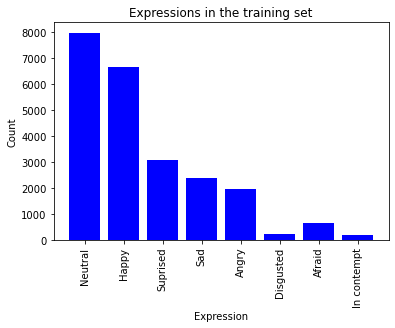

In [7]:
import matplotlib.pyplot as plt

text_labels = ['Neutral','Happy','Suprised','Sad','Angry','Disgusted','Afraid','In contempt']
label_counts = np.bincount(svm_train_set[1])

plt.bar(text_labels, label_counts, facecolor='blue')
plt.title('Expressions in the training set')
plt.ylabel('Count')
plt.xlabel('Expression')
plt.xticks(rotation='vertical')
plt.show()

Figure 2: Overview of how often an expression occurs in the training set.

To combat the class imbalance, weights are assigned to each class so the weighted counts of the different classes are equal.

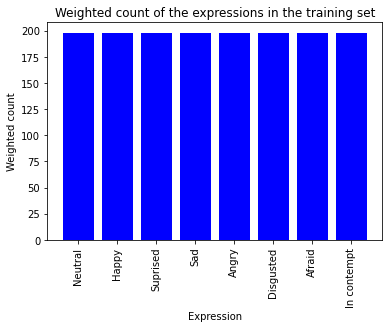

In [8]:
label_counts = np.bincount(svm_train_set[1])
weights = label_counts.min() / label_counts
weights_dict = {}
for i in range(len(weights)):
    weights_dict[i] = weights[i]

plt.bar(text_labels, label_counts*weights, facecolor='blue')
plt.title('Weighted count of the expressions in the training set')
plt.ylabel('Weighted count')
plt.xlabel('Expression')
plt.xticks(rotation='vertical')
plt.show()

Figure 3: The weighted counts for all classes are equal.

### Hyperparameter tuning using Cross Validation

Multiple kernel functions can be used for an SVM, and each kernel function takes certain parameters. To figure out which setting works best for the problem, multiple tests are performed. Cross validation is used to obtain reliable results. 

Scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) simplifies performing these tests. GridSearchCV allows for easily performing an exhaustive search over the given parameters. By default, 5-fold cross validation is used to evaluate how a model performs using a certain setting. Since this process takes a couple of hours, the results have been summerized below, and this step can be skipped.

In [ ]:
from sklearn import svm

params = [
    {
        'kernel': ['linear'],
        'C': [0.5, 1, 5, 10, 15, 20, 25, 50, 100],
        'tol': [1e-3],
        'class_weight': [weights_dict]
    },
    {
        'kernel': ['rbf'],
        'C': [0.5, 1, 5, 25, 100, 250, 500, 1000, 2500],
        'gamma': [1, 3, 5, 7],
        'tol': [1e-3],
        'class_weight': [weights_dict]
    },
    {
        'kernel': ['poly'],
        'C': [0.5, 1, 5, 25, 100, 250, 500, 1000, 2500],
        'degree': [3, 5, 7, 9],
        'tol': [1e-3],
        'class_weight': [weights_dict]
    }
]

svc = svm.SVC()
clf = GridSearchCV(svc, params)
clf.fit(svm_train_set[0], svm_train_set[1])
print(clf.cv_results_)

Each table summerizes for a different kernel function the mean achieved accuracies (score) when performing 5-fold cross validation using a certain setting. Since the mean scores using the rbf-kernel achieves the most promising results, these scores have been visualized in figure 4.

#### CV Results Linear Kernel

| C          | 0.5      | 1       | 5        | 10       | 15       | 20       | 25       | 50       | 100      |
|------------|----------|---------|----------|----------|----------|----------|----------|----------|----------|
| __Mean Score__ | 0.47240 | 0.49851 | 0.53551 | 0.54432 | 0.54846 | 0.55072 | 0.55008 | 0.54957 | 0.54935 |

Table 1: Results of the cross-validation tests using a linear kernel. The table indicates the mean achieved score for a varying _C_ parameter.

#### CV Results Rbf Kernel

| gamma\C | 0.5     | 1       | 5       | 25      | 100     | 250     | 500     | 1000    | 2500    |
|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| __1__   | 0.44762 | 0.49723 | 0.58534 | 0.65147 | 0.67689 | 0.68634 | 0.68660 | 0.68732 | 0.68668 |
| __3__   | 0.40189 | 0.49067 | 0.61970 | __0.68685__ | __0.69860__ | __0.69677__ | __0.69673__ | 0.69665 | 0.69618 |
| __5__   | 0.34888 | 0.43953 | 0.61778 | __0.69498__ | __0.70371__ | __0.70367__ | __0.70320__ | 0.70312 | 0.70312 |
| __7__   | 0.33163 | 0.37579 | 0.59445 | __0.69848__ | __0.70201__ | __0.70235__ | __0.70175__ | 0.70192 | 0.70192 |

Table 2: Results of the cross-validation tests using an rbf kernel. The table indicates the mean achieved score for varying the _C_ and _gamma_ parameter.


#### CV Results Poly Kernel

| degree\C | 0.5      | 1        | 5        | 25       | 100      | 250      | 500      | 1000     | 2500     |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| __3__    | 0.34134 | 0.36927 | 0.48173 | 0.54309 | 0.56779 | 0.57566 | 0.58184 | 0.58980 | 0.60334 |
| __5__    | 0.34368 | 0.38413 | 0.49821 | 0.56425 | 0.58686 | 0.59329 | 0.59968 | 0.61054 | 0.62561 |
| __7__    | 0.35152 | 0.39780 | 0.50059 | 0.57503  | 0.59661 | 0.60436 | 0.61501 | 0.62387 | 0.64111 |
| __9__    | 0.35914 | 0.40342 | 0.49706 | 0.57226 | 0.60441 | 0.61194 | 0.62408 | 0.63519 | 0.64959 |

Table 3: Results of the cross-validation tests using a polynomial kernel. The table indicates the mean achieved scores for varying the _C_ and _degree_ parameter.

### Further improving the achieved accuracy

Since accuracies achieved using the rbf kernel look the most promising, additional cross validation tests using this kernel were performed. The results from these tests are summerized in table 4. See also figure 4 for a visualization of the scores.

| gamma\C | 50      | 55       | 60       | 65       | 70      | 75      | 80      | 100     | 125     | 150     |
|---------|---------|----------|----------|----------|---------|---------|---------|---------|---------|---------|
| __4__  | 0.70082 | 0.70137  | 0.70244  | 0.70210  | 0.70201 | 0.70141 | 0.70201 |         | 0.70107 | 0.70112 |
| __5__  | __0.70278__ | __0.70333__  | __0.70380__  | __0.70401__  | __0.70376__ | __0.70422__ | 0.70371 | 0.70371 | 0.70388 | 0.70376 |
| __6__  | __0.70371__ | __0.70444__  | __0.70444__  | __0.70418__  | __0.70431__ | __0.70414__ | 0.70418 |         | 0.70367 | 0.70337 |
| __7__  |         | __0.70197__ | __0.70235__ | __0.70256__ |         |         |         |         |         |         |
| __8__  |         | 0.69967 | 0.69984  | 0.69988 |         |         |         |         |         |         |

Table 4: Results of the additional cross-validation tests using an rbf kernel. The table indicates the mean achieved scores for varying the _C_ and _gamma_ parameter.

|![Visualization of the mean scores of cross validation using the rbf kernel.](./content/rbf1.png)|![Visualization of the mean scores of cross validation using the rbf kernel.](./content/rbf2.png)|
|---|---|

Figure 4: Visualization of the mean scores of the cross validation tests using the rbf kernel. The values in bold in table 2 have been visualized on the left side, the values in bold in table 4 have been visualized on the right side. The highest achieved accuracies in both graphs have been underlined.

### Training the final model

Based on the results from the previous tests, it is expected that using an __rbf kernel__ with __C=60__ and __gamma=6__ will achieve positive results. An SVM classifier is trained using this setting and all of the data in the training set and validation set, after which it is stored to the file _final\_svm.model_. This step might take a few minutes to complete.

In [9]:
from sklearn import svm
import pickle

model = svm.SVC(kernel='rbf', class_weight=weights_dict,  gamma=6, C=60, tol=1e-3)
model.fit(svm_train_set[0], svm_train_set[1])
pickle.dump(model, open('./final_svm.model', 'wb'))
print('Done')

Done


## Qualitative evaluation

As means of qualitative evaluation, it has been made possible for one to either express emotions live in front of a webcam, or to indicate a folder from which image data will be loaded. The predicted confidences for an emotion expressed will be visible on screen, with the label of most likely emotion expressed colored green. The image itself will be rotated as it is being rotated by the predictor, and the landmark locations are displayed as red dots. 

First, the model is loaded and the prediction function is specified.

In [10]:
import pickle
from scipy.special import softmax

model = pickle.load(open('./final_svm.model', 'rb'))
def svm_model_prob_prediction(landmarks):
    """Method to make predictions using the SVM model."""
    return softmax(model.decision_function([np.reshape(landmarks, -1)])[0])

The following piece of code enables displaying the result. See further below for starting the live test or to perform the test loading data from a folder.

In [11]:
import numpy as np
import cv2 as cv
from math import degrees

def prob_to_string(prob: list):   
    """Convert the probabilities to a string which includes the labels."""
    retval = "Neutral: {:.2f}\nHappy: {:.2f}\nSuprised: {:.2f}\nSad: {:.2f}\nAngry: {:.2f}\nDisgusted: {:.2f}\nAfraid: {:.2f}\nIn contempt: {:.2f}".format(*prob)
    return retval

def display(image: np.array, landmarks: list, rotation: tuple, scaling: tuple, prob: list):
    """Display the result."""
    if landmarks is not None:
        rot_mat = cv.getRotationMatrix2D((rotation[0][0], rotation[0][1]), degrees(-rotation[1]), 1)
        image = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
        
        for p in landmarks:
            p = (p[0] * -scaling[1], p[1] * -scaling[1])
            p = (p[0] + scaling[0][0], p[1] + scaling[0][1])
            p = (int(p[0]),int(p[1]))
            cv.circle(image, p, 0, (0,0,255),-1)
        
        prob = np.round(prob, 2)
        pred = np.argwhere(prob == prob.max())
        prob_list = prob_to_string(prob).split('\n')
        for i, text in enumerate(prob_list):
            image = cv.putText(image, text, (10,(i+1)*20), cv.FONT_HERSHEY_PLAIN, 1, (50, 255, 50) if i in pred else (50, 50, 255), 1, cv.LINE_4)

        cv.imshow('Prediction', image)
        return image
    return None

### Live test

The predictor model is loaded, after which frames are being read from the webcam stream. In case a face is detected in the stream, a prediction is made, which is shown in a different window. Press 'q' to quit.

In [12]:
def live_test(prediction_fn):  
    """Run the live test environment."""
    model = pickle.load(open('./final_svm.model', 'rb'))
    stream = cv.VideoCapture(0)   
    while(True): 
        ret, frame = stream.read()     
        cv.imshow('Stream', frame) 
        landmarks, rotation_info, scaling_info = retrieve_landmarks(frame)
        if landmarks is not None:
            prob = prediction_fn(landmarks)
            display(frame, landmarks, rotation_info, scaling_info, prob)
        if cv.waitKey(1) & 0xFF == ord('q'): 
            break
    stream.release() 
    cv.destroyAllWindows() 
    print('The live test environment closed.')

In [13]:
live_test(svm_model_prob_prediction)

The live test environment closed.


### Using image folder

Predictions are made on the images in the specified folder. The predictions are displayed on screen, as well as saved to the output folder. Press any button to go to the next image.

In [14]:
import os

def image_test(in_folder, out_folder, prediction_fn):
    files = os.listdir(folder)
    for f in (f for f in files if f.endswith('.png')):
        img = cv.imread(folder + f)
        landmarks, rotation_info, scaling_info = retrieve_landmarks(img)
        if landmarks is not None:
            prob = prediction_fn(landmarks)
            img = display(img, landmarks, rotation_info, scaling_info, prob)
            if img is not None:
                cv.imwrite(out_folder + f, img)
            if cv.waitKey() & 0xFF == ord('q'): 
                break
        else:
            print('No face detected in {}'.format(f))
    cv.destroyAllWindows() 
    print('The test using loaded images shut down.')

In [15]:
folder = './qualitative_test_folder/'
out_folder = './qualitative_test_folder_out/'
image_test(folder, out_folder, svm_model_prob_prediction)

The test using loaded images shut down.


Through performing the qualitative evaluation, it is concluded that the developed predictor is adequately capable of recognising the facial expressions 'neutral', 'happy', 'angry' and 'surprised'. For the emotion 'sad', the facial expression needs to be well exagerated for the predictor to correctly classify it. For the other emotions, 'afraid', 'disgusted' and 'in contempt', it was almost impossible to have the classifier predict the performed expression. The model mainly struggles with differing 'afraid' from 'surpised', and 'disgusted' from 'angry'. The predictor was not able to correctly classify any 'in contempt' expression during qualitative evaluation.

## Quantitative evaluation

The numerical performance measures are calculated using the previously unused test set part of the dataset. The trained SVM model is now used to make predictions for this test set. Loading the test set might take a minute.

In [16]:
test_set = load_test()
svm_test_set = svm_preprocessing(test_set)

3573/3573


With the test set loaded, a plot can be drawn for the number of the expressions per class in the test set. The distribution is similar to the distribution of the expressions in the set used for training.

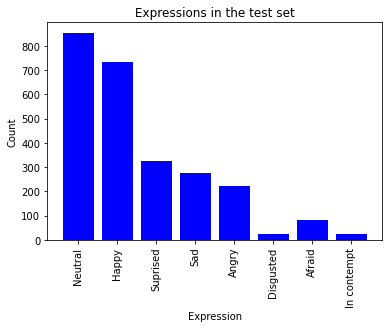

In [17]:
label_counts = np.bincount(svm_test_set[1])

plt.bar(text_labels, label_counts, facecolor='blue')
plt.title('Expressions in the test set')
plt.ylabel('Count')
plt.xlabel('Expression')
plt.xticks(rotation='vertical')
plt.show()

Figure 5: Overview of how often an expression occurs in the test set.

### Accuracy and F-score

Using the test set, the accuracy of correct predictions by the model is calculated. The accuracy indicates the fraction of the set for which the predicted expression is equal to the expression assigned after using majority voting.

Besides the accuracy, the precision, recall and F-score for the individual classes are calculated. 
- The precision is given as TP/(TP+FP)
- The recall is given as TP/(TP+FN)
- The f-score is the harmonic mean between the precision and the recall, defined as  2 \* (precision \* recall) / (precision + recall)

With TP being the number of true positives, FP the number of false positives and FN the number of false negatives.

In [18]:
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = pickle.load(open('./final_svm.model', 'rb'))
pred = model.predict(svm_test_set[0])
acc = accuracy_score(svm_test_set[1], pred)
precision, recall, f1, support = precision_recall_fscore_support(svm_test_set[1], pred, average=None)

print('Accuracy: {}'.format(acc))
print()
print(text_labels)
print('Precision: {}'.format([float('{:.2f}'.format(p)) for p in precision]))
print('Recall: {}'.format([float('{:.2f}'.format(r)) for r in recall]))
print('F-Score: {}'.format([float('{:.2f}'.format(f)) for f in  f1]))

Accuracy: 0.7194018103109012

['Neutral', 'Happy', 'Suprised', 'Sad', 'Angry', 'Disgusted', 'Afraid', 'In contempt']
Precision: [0.68, 0.82, 0.71, 0.54, 0.66, 0.6, 0.67, 0.67]
Recall: [0.86, 0.86, 0.73, 0.29, 0.52, 0.26, 0.25, 0.08]
F-Score: [0.76, 0.84, 0.72, 0.38, 0.58, 0.36, 0.36, 0.14]


|           | Neutral | Happy | Surprised | Sad  | Angry | Disgusted | Afraid | In contempt |
|-----------|---------|-------|-----------|------|-------|-----------|--------|-------------|
| __Precision__ | 0.68    | 0.82  | 0.71      | 0.54 | 0.66  | 0.60      | 0.67   | 0.67        |
| __Recall__    | 0.86    | 0.86  | 0.73      | 0.29 | 0.52  | 0.26      | 0.25   | 0.08        |
| __F-score__   | 0.76    | 0.84  | 0.72      | 0.38 | 0.58  | 0.36      | 0.36   | 0.14        |

Table 5: Overview of the precision, recall and f-score per class.

Considering the problem and the dataset, an accuracy of 71.9% is satisfactory (see also the section ['Achieved test result'](#Achieved-test-result)). 

The high recall scores for 'neutral', 'happy' and 'surprised' indicate that these expression are often correctly predicted. With the recall for 'neutral' being quite a lot higher than the precision for this expression, it can also be concluded that faces in images expressing other emotions are often wrongly classified as being neutral. 

A rather low recall for 'sad', 'disgusted' and 'afraid' shows that the model struggles with correctly classifying these expressions. A very low recall for 'in contempt' shows that the model is unable to correctly predict this expression. However, the precision scores for the expressions 'afraid' and 'in contempt' being relatively high indicate that when the model predicts these expressions, the predictions are often correct.

Looking back at the [distribution of the classes in the training set](#Class-imbalance), it is no surprise that the model performs best on the 'happy' expression, as this is the most often occuring expression, apart from the 'neutral' expression. 

### Confusion matrix

To get a deeper insight in for which class a certain emotion is often mistaken, a confusion matrix is drawn up. The matrix shows the achieved accuracy for the different classes, and indicates for which class it is most likely to be confused.

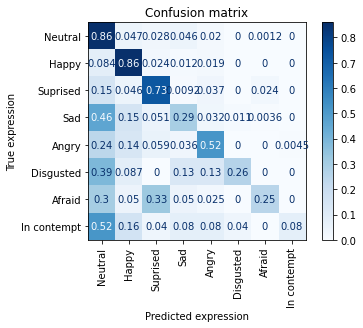

In [19]:
import pickle
from sklearn.metrics import plot_confusion_matrix

model = pickle.load(open('./final_svm.model', 'rb'))
plot = plot_confusion_matrix(model, svm_test_set[0], svm_test_set[1], normalize='true', display_labels=['Neutral', 'Happy', 'Suprised', 'Sad', 'Angry', 'Disgusted', 'Afraid', 'In contempt'], cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.ylabel('True expression')
plt.xlabel('Predicted expression')
plt.xticks(rotation='vertical')
plt.show()

Figure 6: Confusion matrix for the test set.

Analyzing the confusion matrix confirms the earlier finding of faces most often being mistaken for having a neutral expression. In addition to the previous finding, the confusion matrix also shows that an 'afraid' expression is most likely to be classified as a 'surprised' expression. In hindsight, this is no surprise, as both facial expressions are very similar.

### Effect of class weighting

To get an insight in the importance of weighting the classes, a confusion matrix can be drawn up using a model trained without balancing the classes. The _C_ and _gamma_ parameters have been decided on using the same method as explained in [the section about hyperparameter tuning](#Hyperparameter-tuning-using-Cross-Validation). Since a new model is being fitted, this step might take a few minutes to complete.

Accuracy: 0.7241243604879969


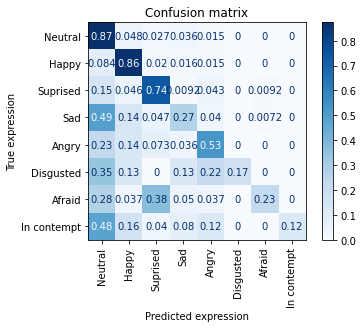

In [20]:
unbalanced_model = svm.SVC(kernel='rbf', gamma=5, C=800, tol=1e-3)
unbalanced_model.fit(svm_train_set[0], svm_train_set[1])
unbalanced_pred = unbalanced_model.predict(svm_test_set[0])

print('Accuracy: {}'.format(accuracy_score(svm_test_set[1], unbalanced_pred)))
plot = plot_confusion_matrix(unbalanced_model, svm_test_set[0], svm_test_set[1], normalize='true', display_labels=['Neutral', 'Happy', 'Suprised', 'Sad', 'Angry', 'Disgusted', 'Afraid', 'In contempt'], cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.ylabel('True expression')
plt.xlabel('Predicted expression')
plt.xticks(rotation='vertical')
plt.show()

Figure 7: Confusion matrix for the test set using a model fitted without weighting the classes.

As could be expected, the model fitted without balancing the classes achieves a higher test accuracy, since the distribution in the test set is similar to the distribution in the training set. When comparing figure 6 and figure 7, it can be noted however that balancing the classes increases the recall for the 'sad' class and the minority classes 'disgusted' and 'afraid'. Suprisingly, not balancing the classes causes a higher recall for the 'in contempt' class, although it is still very low.

## Conclusion & critical closing remarks

Summerized, the model performs well on the expressions 'neutral', 'happy', 'surprised' and 'angry', and subpar on the expressions 'sad', 'disgusted', 'afraid' and 'in contempt'. Looking at the distribution of the expressions in the dataset, the occurance of an expression in the dataset is related to how well the expression is classified. The trained classifier achieved an accuracy of 71.9% on the test set. 

### Used dataset

During the qualitative evaluation, it became clear that emotions need to be expressed very clearly for the model to be able to make a correct prediction. This is possbily due to the data used for training being images taken of a person who is exaggerating an expressing or acting out a certain emotion. To avoid the model overfitting on exaggerated expressions, it would be better to use a dataset with images of people being unaware of their expressions being captured. Another possibility would be to film a person changing their expression from 'neutral' to another expression. This would allow for using all frames of the transformation as training data, and not only using the images were a person is already clearly expressing an emotion.

Furthermore, it would be beneficial for the classifier being trained to have a better balance of emotions in the dataset. It was attempted to counter the imbalance in the dataset by weighting the classes. This did however decrease the accuracy achieved for the test set, which is due to the distribution of the expressions in the test set being similar to the distribution in the set used for training. Not weighting the classes trains a classifier that is more likely to correctly predict the most often occuring expressions, but at a cost of correctly predicting minority classes. Yet, even when using weighted classes, it is almost impossible for the classifier to correctly predict the three least common emotions 'afraid', 'disgusted' and 'in contempt'. Using data augmentation techniques to create synthetic new data of the minority classes could prove useful for improving these result. One should however manually relabel the synthetic data, as transforming the image might result in another emotion being expressed.

Besides the emotion on which the model struggels being underpopulated in the dataset, the emotions are not very distinct. A person expressing 'in contempt' is closely resembling a 'neutral' expression, and with only an image available and no sound, the expression for 'afraid' is very similar to 'surprised'. In daily life, the most distinct difference between the last two emotions is that people produce noise when they are afraid, and are silent when surprised.

### Achieved test result

The original FER dataset was constructed in 2013 by Pierre Luc Carrier and Aaron Courville as part of the ICML 2013 workshop on Challenges in Representation Learning. The [workshop leaderboard](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard) shows that the highest achieved accuracy during the workshop was 0.71161 on the test set. The three highest scoring teams all used convolutional neural networks and used data augmentation to extend the set available for training. (Goodfellow et al., 2015)

Relative to these scores, the developed model performs exceptionally well. However, it should be kept in mind that the scores in the leaderboard date back from 2013. Furthermore, the developed predictor has been trained using the FER+ dataset. It can be assumed that the labels in the FER+ dataset are more accurate, and thus contribute in achieving higher accuracies.

Relative to the scores achieved in the paper proposing FER+ by Barsoum et al., the developed method achieves a low accuracy. The paper takes a CNN approach using a custom VGG13 model with 10 convolutional layers. When using multi-label learning, the model achieved a test accuracy of 83.966. (Barsoum et al., 2016)

The most significant difference between the method by Barsoum et al. and the method developed in this work, is the information available per sample. While this method only takes the positions of facial landmarks into account, the method by Barsoum uses the pixel data of the image. Using the pixel data, additional information, for example the presence and shape of wrinkles around the eyes, can be used in deciding which emotion is being expressed. This additional information contributes in achieving a higher test accuracy.

### Improvements

The current model does achieve an adequate test accuracy on the used dataset, taking into consideration that facial landmarks have been used to classify the expressions. As indicated by the result achieved by Barsoum et al., it is however expected that a higher test accuracy will be achieved when using the image data and a convolutional neural network. Futhermore, it would be interesting to research whether a hybrid method which takes the positions of the landmarks as well as the pixel data into account would be able to achieve an even higher accuracy.

## References


Barsoum, E., Zhang, C., Canton Ferrer, C., & Zhang, Z. (2016). Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution. In _ACM International Conference on Multimodal Interaction (ICMI)_.

Goodfellow, I.J., Erhan, D., Carrier, P.L., Courville, A.C., Mirza, M., Hamner, B., Cukierski, W., Tang, Y., Thaler, D., Lee, D., Zhou, Y., Ramaiah, C., Feng, F., Li, R., Wang, X., Athanasakis, D., Shawe-Taylor, J., Milakov, M., Park, J., Ionescu, R.T., Popescu, M., Grozea, C., Bergstra, J., Xie, J., Romaszko, L., Xu, B., Zhang, C., & Bengio, Y. (2015). Challenges in representation learning: A report on three machine learning contests. _Neural networks: the official journal of the International Neural Network Society_, 64, 59-63.

Van Gent, P. (2016, August 05). _Emotion Recognition using Facial Landmark, Python, DLib and OpenCV_. [https://theonly1.tistory.com/106]()

Swethan, R. (2018, March 08). _Emotion detection using facial landmarks and deep learning_. [https://medium.com/@rishiswethan.c.r/emotion-detection-using-facial-landmarks-and-deep-learning-b7f54fe551bf](https://medium.com/@rishiswethan.c.r/emotion-detection-using-facial-landmarks-and-deep-learning-b7f54fe551bf)